In [4]:
# First, let's install TensorFlow using pip
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 118.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 119.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 128.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 134.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.1/397.1 kB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:


# Then we can keep the original imports
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
import os
from skimage.measure import label
import tifffile as tiff

import matplotlib.pyplot as plt
import random

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from scipy.ndimage import binary_fill_holes

2025-05-15 11:36:51.273945: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 11:36:51.277137: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 11:36:51.282643: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 11:36:51.293890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747323411.313602     101 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747323411.31

In [10]:
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [13]:
import numpy as np

# Path to your .npz file in Google Drive

file_path = 'stardist/tissuenet_v1.1_test.npz'
# Load the file
data = np.load(file_path)

# Check the contents
print(data.files) 

['X', 'y', 'meta']


In [16]:
# Access the masks and annotations
masks = data['y']
#annotations = data['annotations']
image_set = data['X']

# Print the shapes to check
print("Masks shape:", masks.shape)
#print("Annotations shape:", annotations.shape)


Masks shape: (1324, 256, 256, 2)


In [19]:
# --- Initialize lists to store predictions and valid indices ---
Y_pred = []
valid_indices = []
prob_maps = []

# --- Load and prepare data ---
imgs = image_set[:, :, :, 0]  # Grayscale input
masks_y = masks[:, :, :, 1]   # Ground truth masks
X_norm = [normalize(x, 1, 99.8, axis=None) for x in tqdm(imgs, desc="Normalizing images")]

# Add this line to ensure correct shape
X_norm = [x[..., np.newaxis] if x.ndim == 2 else x for x in X_norm]

model = StarDist2D.from_pretrained("2D_versatile_fluo")

save_dir = "stardist_predictions"
os.makedirs(save_dir, exist_ok=True)

for i in tqdm(range(len(X_norm)), desc="Evaluating StarDist"):
    sample_img = X_norm[i]
    gt_mask = label(masks_y[i] > 0)

    if len(np.unique(gt_mask)) <= 1:
        print(f"Image {i+1} skipped (no GT objects)")
        continue

    try:
        # --- Predict raw probability map ---
        prob_map, _ = model.predict(sample_img)
        prob_maps.append(prob_map)

        # --- Predict instances ---
        pred_mask, _ = model.predict_instances(
            sample_img,
            n_tiles=model._guess_n_tiles(sample_img),
            show_tile_progress=False
        )

        Y_pred.append(pred_mask)
        valid_indices.append(i)

        # Save prediction
        tiff.imwrite(os.path.join(save_dir, f"pred_{i+1:04d}.tif"), 
                    pred_mask.astype(np.uint16))

    except Exception as e:
        print(f"Error processing image {i+1}: {str(e)}")
        continue

# --- Filter ground truth masks to match predictions ---
masks_y_filtered = [masks_y[i] for i in valid_indices]

Normalizing images: 100%|██████████| 1324/1324 [00:02<00:00, 506.05it/s]Found model '2D_versatile_fluo' for 'StarDist2D'.

5320433/5320433 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
E0000 00:00:1747323462.694254     101 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1747323462.842703     101 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Evaluating StarDist:   0%|          | 0/1324 [00:00<?, ?it/s]functional.py (

In [25]:
def get_object_count(mask):
    return len(np.unique(mask)) - 1  # exclude background label 0

def get_total_area(mask):
    return np.sum(mask > 0)


# Calculate counts and areas
Stardist_counts = [get_object_count(m) for m in Y_pred]
Stardist_areas = [get_total_area(m) for m in Y_pred]

# Some summary statistics
print(f"Average predicted objects per image: {np.mean(Stardist_counts):.2f}")
print(f"Average predicted area per image: {np.mean(Stardist_areas):.2f}")

Average predicted objects per image: 84.52
Average predicted area per image: 19055.41


In [34]:
import pandas as pd

# Create the DataFrame
df_cellpose = pd.DataFrame({
    'image_index': list(range(len(Y_pred))),
    'object_count': Stardist_counts,
    'total_area': Stardist_areas
})

# Display the DataFrame
print(df_cellpose.head())
# Save the DataFrame to a CSV file in the /work directory
df_cellpose.to_csv('/work/StarDist_results.csv', index=False)

   image_index  object_count  total_area
0            0            89       22940
1            1           127       23950
2            2           138       29648
3            3           185       23076
4            4           177       26916


In [55]:
# First convert predictions into full-size format aligned with ground truth
Y_pred_full = np.zeros_like(masks_y)
for idx, pred in zip(valid_indices, Y_pred):
    Y_pred_full[idx] = pred

# Define thresholds for evaluation  
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Compute matching statistics across thresholds
stats_per_tau = {
    t: matching_dataset(masks_y, Y_pred_full, thresh=t, show_progress=False) 
    for t in tqdm(taus, desc="Computing matching stats")
}

# Print all stats
for t, stats in stats_per_tau.items():
    print(f"Tau = {t:.1f} --> {stats}")


Computing matching stats: 100%|██████████| 9/9 [00:47<00:00,  5.27s/it]Tau = 0.1 --> DatasetMatching(criterion='iou', thresh=0.1, fp=6624, tp=103840, fn=31793, precision=0.9400347624565469, recall=0.7655953934514462, accuracy=0.7299465052686336, f1=0.8438948869754609, n_true=135633, n_pred=110464, mean_true_score=0.5559337506602186, mean_matched_score=0.726145631772895, panoptic_quality=0.612790585852712, by_image=False)
Tau = 0.2 --> DatasetMatching(criterion='iou', thresh=0.2, fp=6931, tp=103533, fn=32100, precision=0.9372555764774044, recall=0.7633319324943045, accuracy=0.7262212059145366, f1=0.8413999357976732, n_true=135633, n_pred=110464, mean_true_score=0.5556158696452969, mean_matched_score=0.727882387717931, panoptic_quality=0.6124401942941243, by_image=False)
Tau = 0.3 --> DatasetMatching(criterion='iou', thresh=0.3, fp=8003, tp=102461, fn=33172, precision=0.9275510573580533, recall=0.7554282512367934, accuracy=0.7133378818680554, f1=0.8326879238674181, n_true=135633, n_pred=

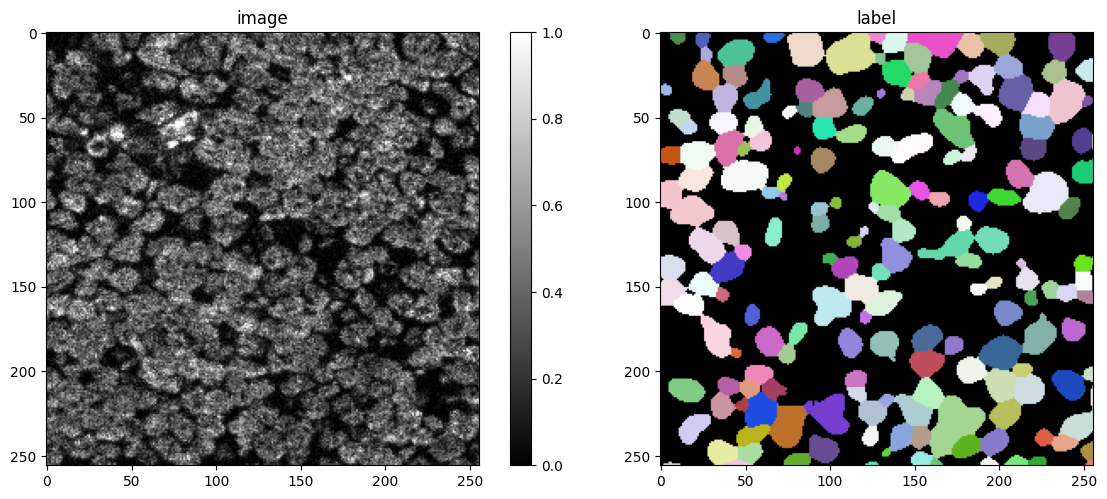

In [58]:
from csbdeep.utils import normalize  # if not already imported

# Random color map labels
np.random.seed(42)
lbl_cmap = random_label_cmap()

def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    # --- Normalize image (percentile based) ---
    img = normalize(img, 1, 99.8)  # or 0, 100 for full range normalization

    fig, (ai, al) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw=dict(width_ratios=(1.25, 1)))
    im = ai.imshow(img, cmap='gray', clim=(0, 1))  # image now has values in [0,1]
    ai.set_title(img_title)
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

# Use for plotting
i = min(9, len(imgs) - 1)
img, lbl = imgs[0], masks_y[0]
img = img if (img.ndim == 2 or img.shape[-1] == 3) else img[..., 0]

plot_img_label(img, lbl)


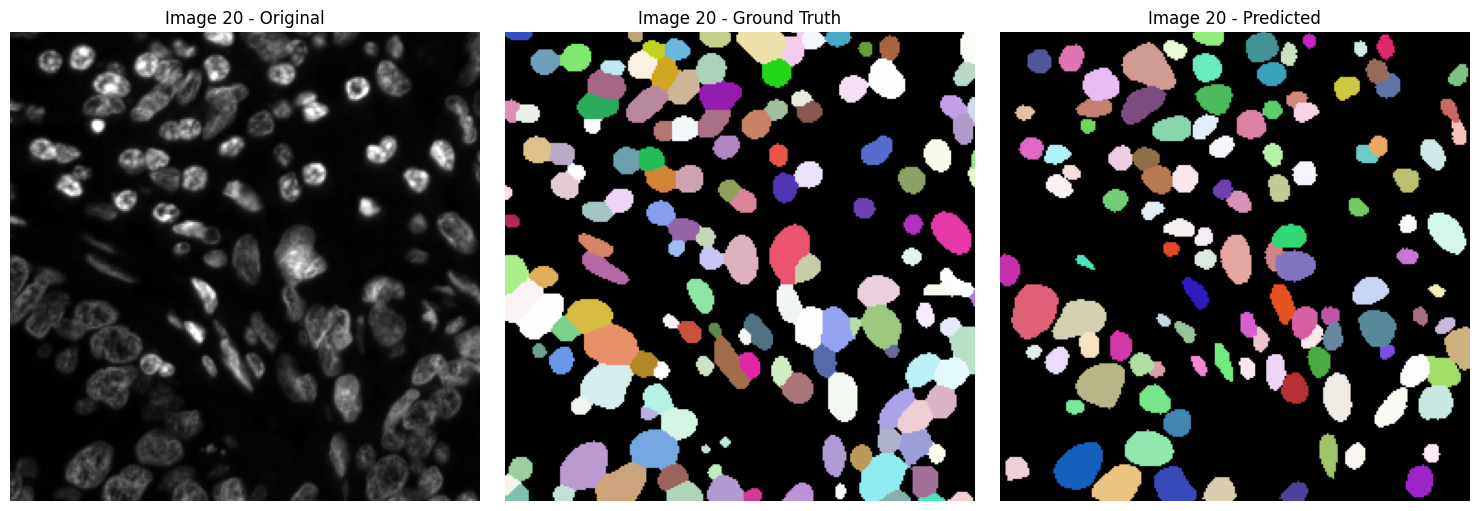

In [22]:
from csbdeep.utils import normalize
import matplotlib.pyplot as plt
import numpy as np
from stardist.plot import random_label_cmap

# --- Setup label colormap ---
np.random.seed(42)
lbl_cmap = random_label_cmap()

# --- Display function ---
def plot_image_gt_pred(img, gt_mask, pred_mask, idx=None):
    # Normalize image using percentile-based approach
    img = normalize(img, 1, 99.8)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img, cmap='gray', clim=(0, 1))
    axes[0].set_title(f"Image {idx} - Original" if idx is not None else "Original Image")
    axes[0].axis('off')

    axes[1].imshow(gt_mask, cmap=lbl_cmap)
    axes[1].set_title(f"Image {idx} - Ground Truth" if idx is not None else "Ground Truth")
    axes[1].axis('off')

    axes[2].imshow(pred_mask, cmap=lbl_cmap)
    axes[2].set_title(f"Image {idx} - Predicted" if idx is not None else "Prediction")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Get a valid index to plot
valid_idx = valid_indices[min(20, len(valid_indices) - 1)]  # Get the 9th valid index or last if fewer

# Get corresponding images and masks
img = imgs[valid_idx]
img = img if (img.ndim == 2 or img.shape[-1] == 3) else img[..., 0]
gt_mask = masks_y[valid_idx]
pred_mask = Y_pred[valid_indices.index(valid_idx)]  # Get corresponding prediction

# Plot the results
plot_image_gt_pred(img, gt_mask, pred_mask, valid_idx)

Prediction analysis results saved in: stardist_predictions_data

Files created:
1. stardist_predictions_metrics.csv - Per-image prediction metrics
2. stardist_global_stats.csv - Global prediction statistics
3. stardist_predictions_summary.txt - Human-readable summary


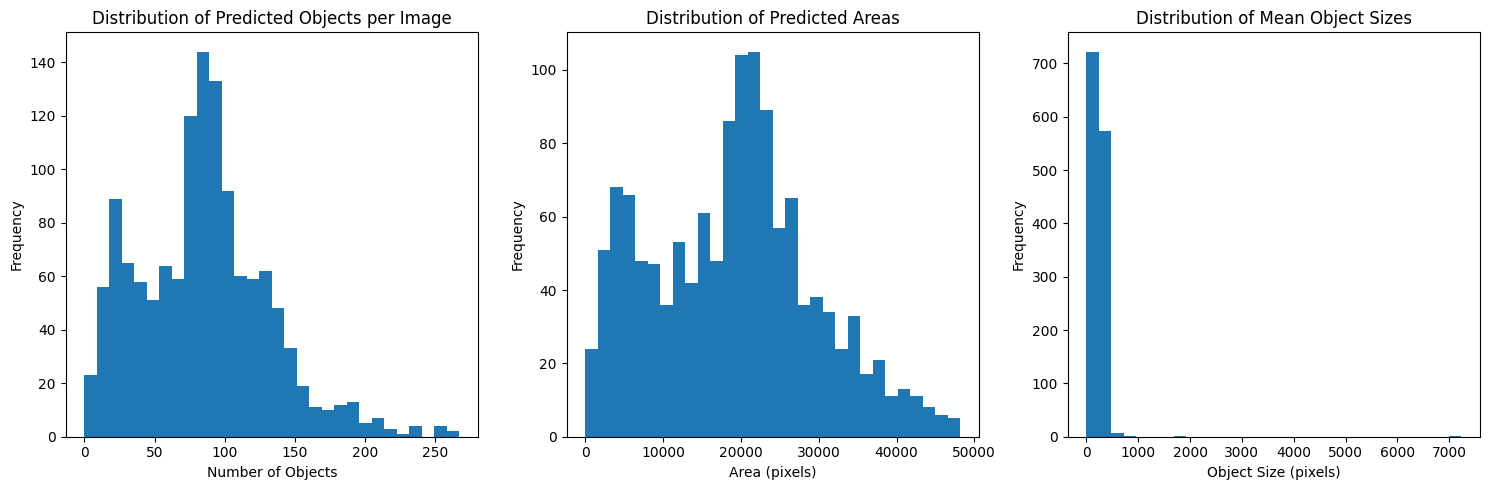

In [70]:
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Calculate metrics for predictions only
def calculate_prediction_metrics(pred_mask):
    """Calculate metrics for a single image prediction"""
    pred_area = np.sum(pred_mask > 0)
    pred_objects = len(np.unique(pred_mask)) - 1  # subtract 1 for background
    
    return {
        'pred_area': pred_area,
        'pred_objects': pred_objects,
        'mean_object_size': pred_area / pred_objects if pred_objects > 0 else 0
    }

# Create results directory
results_dir = "stardist_predictions_data"
os.makedirs(results_dir, exist_ok=True)

# Prepare data storage
prediction_metrics = []

# Calculate metrics for each prediction
for idx, pred in enumerate(Y_pred):
    metrics = calculate_prediction_metrics(pred)
    metrics['image_id'] = valid_indices[idx]
    prediction_metrics.append(metrics)

# Convert to DataFrame
df_metrics = pd.DataFrame(prediction_metrics)

# Calculate global statistics
global_metrics = {
    'model_name': 'StarDist',
    'date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'total_images': len(Y_pred),
    'mean_pred_area': df_metrics['pred_area'].mean(),
    'std_pred_area': df_metrics['pred_area'].std(),
    'mean_object_count': df_metrics['pred_objects'].mean(),
    'std_object_count': df_metrics['pred_objects'].std(),
    'mean_object_size': df_metrics['mean_object_size'].mean(),
    'std_object_size': df_metrics['mean_object_size'].std()
}

# Save results
df_metrics.to_csv(os.path.join(results_dir, 'stardist_predictions_metrics.csv'), index=False)
pd.DataFrame([global_metrics]).to_csv(os.path.join(results_dir, 'stardist_global_stats.csv'), index=False)

# Save summary to text file
with open(os.path.join(results_dir, 'stardist_predictions_summary.txt'), 'w') as f:
    f.write("StarDist Model Predictions Summary\n")
    f.write("=" * 30 + "\n\n")
    f.write(f"Analysis Date: {global_metrics['date']}\n")
    f.write(f"Total Images Processed: {global_metrics['total_images']}\n\n")
    
    f.write("Prediction Statistics:\n")
    f.write(f"Mean Objects per Image: {global_metrics['mean_object_count']:.2f} ± {global_metrics['std_object_count']:.2f}\n")
    f.write(f"Mean Object Size: {global_metrics['mean_object_size']:.2f} ± {global_metrics['std_object_size']:.2f}\n")
    f.write(f"Mean Predicted Area: {global_metrics['mean_pred_area']:.2f} ± {global_metrics['std_pred_area']:.2f}\n")

print("Prediction analysis results saved in:", results_dir)
print("\nFiles created:")
print("1. stardist_predictions_metrics.csv - Per-image prediction metrics")
print("2. stardist_global_stats.csv - Global prediction statistics")
print("3. stardist_predictions_summary.txt - Human-readable summary")

# Optional: Create histograms of the predictions
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.hist(df_metrics['pred_objects'], bins=30)
plt.title('Distribution of Predicted Objects per Image')
plt.xlabel('Number of Objects')
plt.ylabel('Frequency')

plt.subplot(132)
plt.hist(df_metrics['pred_area'], bins=30)
plt.title('Distribution of Predicted Areas')
plt.xlabel('Area (pixels)')
plt.ylabel('Frequency')

plt.subplot(133)
plt.hist(df_metrics['mean_object_size'], bins=30)
plt.title('Distribution of Mean Object Sizes')
plt.xlabel('Object Size (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()